In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data.csv', encoding='ISO-8859-1')

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove cancelled invoices (InvoiceNo starting with C)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [4]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [5]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [6]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Score'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)


In [7]:
def segment_customer(row):
    if row['RFM_Score'] in ['444', '443', '434']:
        return 'Champions'
    elif row['RFM_Score'][1:] == '44':
        return 'Loyal Customers'
    elif row['RFM_Score'][0] == '4':
        return 'Recent Customers'
    elif row['RFM_Score'][0] == '1':
        return 'At Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

rfm.head()


,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,At Risk
12347.0,2,182,4310.00,4,4,4,444,Champions
12348.0,75,31,1797.24,2,2,4,224,Others
12349.0,19,73,1757.55,3,3,4,334,Others
12350.0,310,17,334.40,1,1,2,112,At Risk


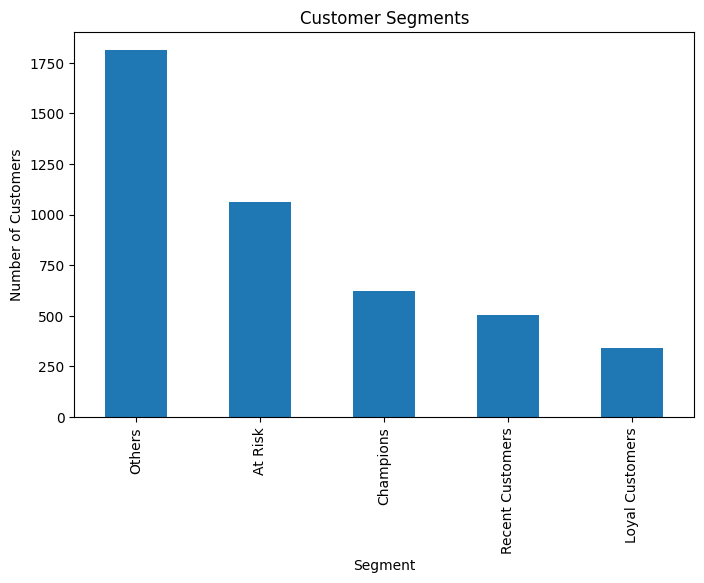

In [8]:
segment_counts = rfm['Segment'].value_counts()

plt.figure(figsize=(8,5))
segment_counts.plot(kind='bar')
plt.title('Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()


In [9]:
rfm.to_csv('rfm_segments.csv')
